# Exercise 10 image stitching

Today’s exercise is different from the previous weeks in that it has only a few exercises followed \
by multiple options for how to improve your algorithm. You are going to implement an algorithm \
that can stitch at least two images together, by using RANSAC to estimate a homography.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import math
import utilis

### EX 10.1 SIFT Features

Load images and find the features of both.

Find SIFT keypoints (kp1, kp2) in both images and compute their descriptors (des1, des2). \
Match the SIFT features from both images to each other. Make sure to use cross checking.

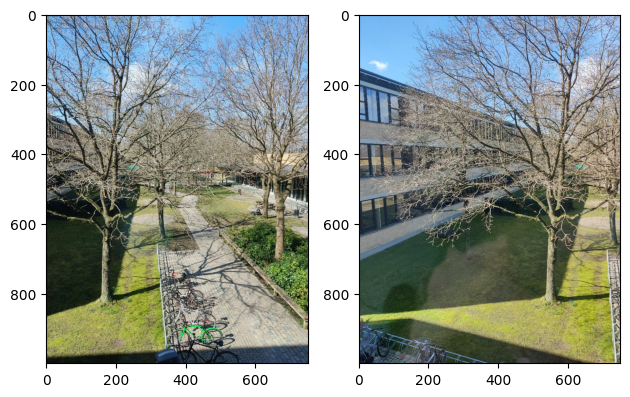

In [2]:
im1 = cv2.imread('images/im1.jpg')[:,:,::-1]
im2 = cv2.imread('images/im2.jpg')[:,:,::-1]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im1)
axs[1].imshow(im2)
plt.tight_layout()
plt.show()

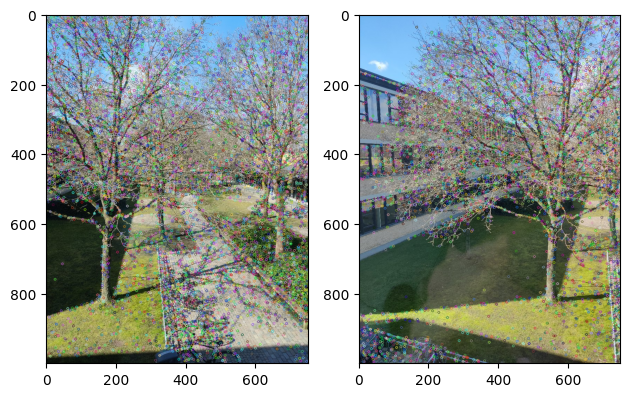

In [3]:
sift = cv2.SIFT.create()
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)
im1_kps = cv2.drawKeypoints(im1, kp1, None)
im2_kps = cv2.drawKeypoints(im2, kp2, None)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im1_kps)
axs[1].imshow(im2_kps)
plt.tight_layout()
plt.show()



In [4]:
#### Brute force
bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des1, des2)
sorted_matches = sorted(matches, key = lambda x:x.distance)

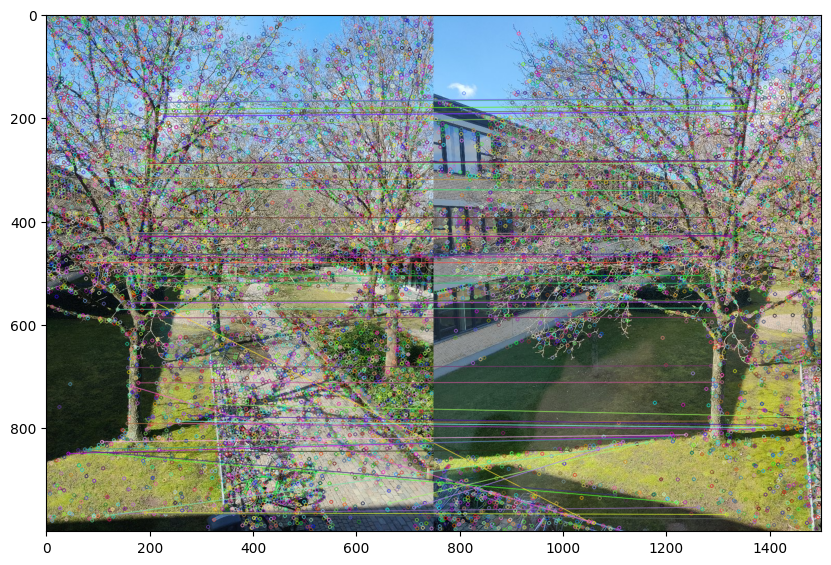

In [5]:
mimg = cv2.drawMatches(im1, kp1, im2, kp2, sorted_matches[:50], None)
plt.figure(figsize = (10,10))
plt.imshow(mimg)

### 10.2 Implement RANSAC for finding homographies between the images.

What is the minimum number of matches you need to estimate a homography?
- H matrix is 3x3, with 9 DoF. But as H is scale invariant (as its multiplying homogenous points) it only has 8 DoF
- Each pair of points imposes 2 constraints (x,y), meaning that four points gives 8 constraints.
- In conclusion, we need four pairs of points.

Use Equation (2.45) from the lecture notes to compute the distance of a match to a homography. \
Assume σ = 3 and use the formulas from the lecture last week to determine the threshold for when \
a match should be considered an inlier. 

While best practice would be to determine the number of  iterations while running the algorithm,\
you can fix it to i.e. 200. 

To verify that the inliers of the best model are reasonable, visualize them.\
Consider using the following code: 
```plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[bestInliers], None))```\

**NB** On the provided images you should find in the ballpark of a thousand inliers

***From week 4***

In [6]:
def sample(matches, kp1, kp2):
    indices = np.random.choice(len(matches), size=4, replace=False)
    sample_kp1 = [kp1[matches[i].queryIdx].pt for i in indices]
    sample_kp2 = [kp2[matches[i].trainIdx].pt for i in indices]
    return np.asarray(sample_kp1).T, np.asarray(sample_kp2).T

def get_inliers(matches, kps1, kps2, H, sigma):
    kps1 = [kps1[match.queryIdx].pt for match in matches]
    kps2 = [kps2[match.trainIdx].pt for match in matches]
    inliers = []
    min = math.inf
    for i in range(len(kps1)):
        kp1 = np.expand_dims(np.asarray(kps1[i]), axis=0).T
        kp2 = np.expand_dims(np.asarray(kps2[i]), axis=0).T
        d1 = np.square(kp1 - utilis.Pi(H @ utilis.PiInv(kp2))).sum()
        d2 = np.square(kp2 - utilis.Pi(np.linalg.inv(H) @ utilis.PiInv(kp1))).sum()
        err = math.sqrt(d1 + d2)
        if err < min: min = err
        if err < 5.99*sigma**2: inliers.append(i)
    return inliers

#### RANSAC for finding homographies

In [7]:
def ransac(matches, kp1, kp2, iterations, sigma):
    best_inl = []
    for i in range(iterations):
        sample_kp1, sample_kp2 = sample(matches, kp1, kp2)
        H = utilis.hest(sample_kp1, sample_kp2)
        inliers = get_inliers(matches, kp1, kp2, H, sigma)
        if len(inliers) > len(best_inl):
            best_inl = inliers
    print(f'Num of inliers: {len(best_inl)}')
    return best_inl

In [8]:
best_inl = ransac(matches, kp1, kp2, 200, 3)

Num of inliers: 974


In [9]:
kps1 = [kp1[matches[i].queryIdx].pt for i in best_inl]
kps2 = [kp2[matches[i].trainIdx].pt for i in best_inl]
H_est = utilis.hest(np.asarray(kps1).T, np.asarray(kps2).T)
print(H_est)

[[ 2.30705782e-03  4.22514605e-05 -9.40048278e-01]
 [ 6.06515261e-04  2.09524182e-03 -3.41023896e-01]
 [ 1.29076261e-06  1.03223264e-08  1.36188082e-03]]


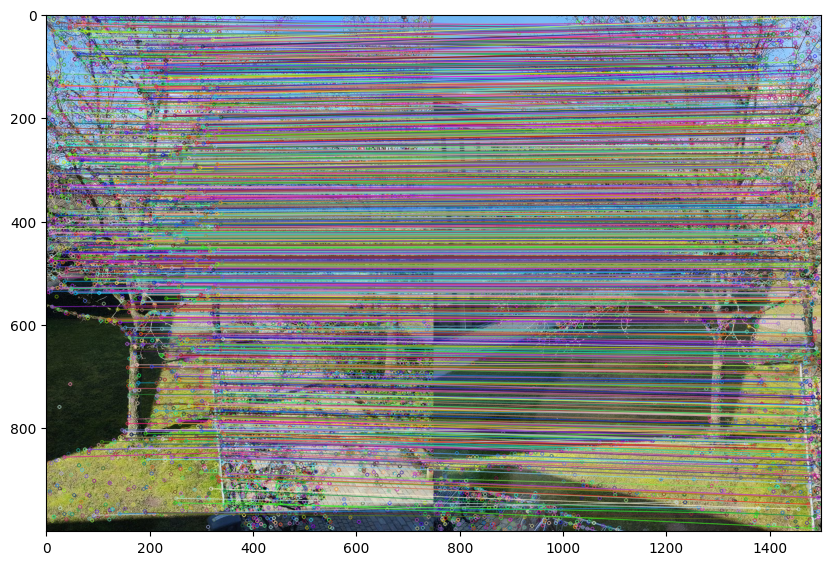

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[best_inl], None))

In [11]:
def estHomographyRANSAC(kp1, des1, kp2, des2):
    bf = cv2.BFMatcher_create(crossCheck=True)
    matches = bf.match(des1, des2)
    best_inl = ransac(matches, kp1, kp2, 200, 3)
    kps1 = [kp1[matches[i].queryIdx].pt for i in best_inl]
    kps2 = [kp2[matches[i].trainIdx].pt for i in best_inl]
    return utilis.hest(np.asarray(kps1).T, np.asarray(kps2).T)

In [12]:
H = estHomographyRANSAC(kp1, des1, kp2, des2)
print(H)

Num of inliers: 975
[[ 2.30593944e-03  4.21255178e-05 -9.39618330e-01]
 [ 6.08312434e-04  2.09376593e-03 -3.42206775e-01]
 [ 1.29439223e-06  1.03114353e-08  1.35798683e-03]]


### 10.4 Warping images.

The warping function takes an image and a homography and returns the image warped with the homography, where \
xRange and yRange specifies for which range of x and y values the image should be sampled. The function returns \
the transformed version of the image, and a mask that is 1 where the image is valid.

Start out by setting:
```
xRange = [0, im1.shape[1]]
yRange = [0, im1.shape[0]]
```

Warp one of your images using the estimated homography. Which image you should warp, depends on if you have found \
the homography going from image one to two or vice versa. This should warp this image to the other, thus cutting \
off a lot of the content of that image.

Use the warping function on the other image but set the homography to the identity. \
Change xRange and yRange so the images are no longer getting cropped by the warp.

In [13]:
def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    mask = np.ones(im.shape[:2], dtype=np.uint8)*255
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(mask, H, outSize)
    return imWarp, maskWarp

In [ ]:
def warp_image(source_image, homography_matrix, output_shape):
    """
    Warp the source image using the homography matrix.

    Parameters:
    source_image (ndarray): The source image to be warped.
    homography_matrix (ndarray): The 3x3 homography matrix.
    output_shape (tuple): The shape (height, width) of the output (warped) image.

    Returns:
    warped_image (ndarray): The warped output image.
    """
    warped_image = cv2.warpPerspective(source_image, homography_matrix, output_shape)
    return warped_image

Useful pixel left 61.70409071428571


Useful pixel right 61.70409071428571


Text(0.5, 1.0, 'warped right image')

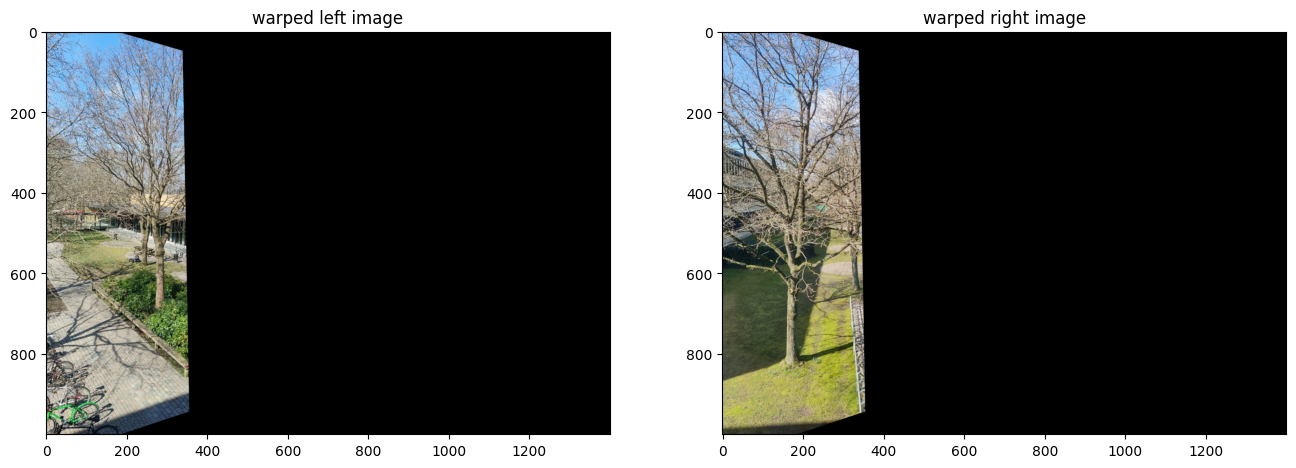

In [14]:
xRange = [0, 1400]
yRange = [0, im1.shape[0]]

left_warp, left_mask = warpImage(im1, H, xRange, yRange)
print("Useful pixel left", np.mean(left_mask))

right_warp, right_mask = warpImage(im2, H, xRange, yRange)
print("Useful pixel right", np.mean(right_mask))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,12))
axs[0].imshow(left_warp, cmap="gray")
axs[0].set_title("warped left image")
axs[1].imshow(right_warp, cmap="gray")
axs[1].set_title("warped right image")

### 10.5 Combine images

Use the mask returned by the warping function, to generate a single image that contains both \
images. Where the images overlap you can use the intensities from either image.

**TODO** Use the mask to interpolate in the overlaps
**TODO** Use non-linear optimization of the final hest?

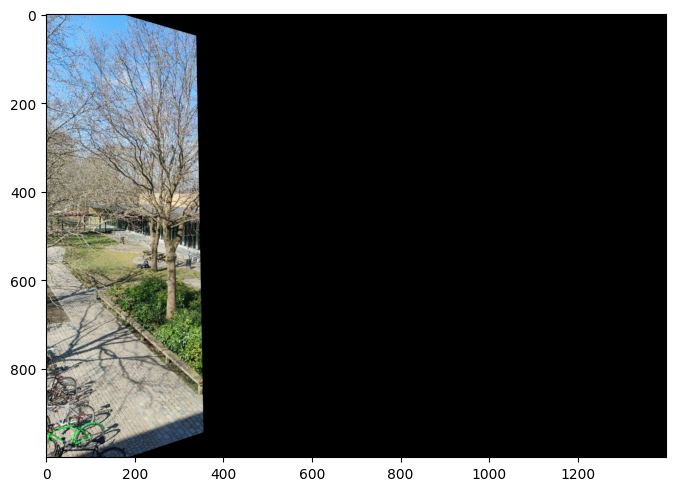

In [15]:
# Since the right image is the base image, we use the left image as canvas, and draw the right image on top.
canvas = right_warp.copy()
canvas[:, 0:im1.shape[1]] = left_warp[:, 0:im1.shape[1]]
canvas[:, 0:400] = left_warp[:, 0:400]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axs.imshow(canvas, cmap="gray")

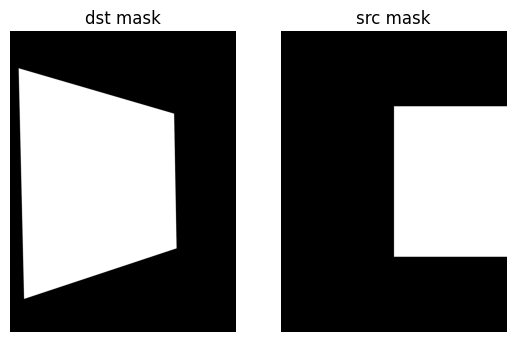

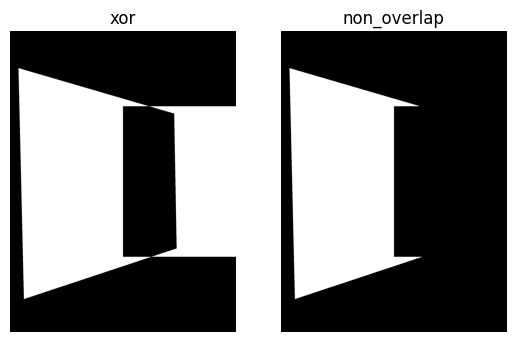

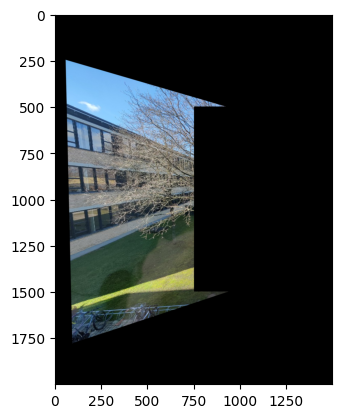

In [17]:
xRange = [-im1.shape[1], im1.shape[1]]
yRange = [int(-0.5 * im1.shape[0]), int(1.5 * im1.shape[0])]

dst_warp_im, dst_warp = warpImage(im2, H, xRange, yRange)
src_warp_im, src_warp = warpImage(
    im1, np.eye(3), 2 * xRange, 2 * yRange
)  # reference

fig, ax = plt.subplots(1, 2)
ax[0].imshow(dst_warp, cmap="gray")
ax[0].set_title("dst mask")
ax[0].axis("off")
ax[1].imshow(src_warp, cmap="gray")
ax[1].set_title("src mask")
ax[1].axis("off")
plt.show()

xor = np.logical_xor(dst_warp, src_warp)
non_overlap = np.logical_and(xor, dst_warp)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(xor, cmap="gray")
ax[0].set_title("xor")
ax[0].axis("off")
ax[1].imshow(non_overlap, cmap="gray")
ax[1].set_title("non_overlap")
ax[1].axis("off")
plt.show()

new_dst_img = dst_warp_im.copy()
new_dst_img[non_overlap != 1] = 0
plt.imshow(new_dst_img)
plt.show()